In [26]:
from matplotlib import font_manager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, mean_squared_error

def nsknn_impute_df(data: pd.DataFrame, k: int = 5) -> pd.DataFrame:
    imputed_data = data.copy()
    for col in data.columns:
        missing_indices = data[data[col].isna()].index
        for idx in missing_indices:
            target_row = data.loc[idx, :]
            valid_rows = data[data[col].notna()]
            distances = pairwise_distances(
                valid_rows.fillna(0),
                target_row.fillna(0).values.reshape(1, -1),
                metric='nan_euclidean'
            ).flatten()
            neighbor_indices = valid_rows.index[np.argsort(distances)[:k]]
            neighbors = valid_rows.loc[neighbor_indices, col]
            imputed_value = neighbors.mean()
            imputed_data.at[idx, col] = imputed_value
    return imputed_data

def compare_real_and_imputed(data: pd.DataFrame, impute_func, k: int = 5, test_size: float = 0.2):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    test_data_missing = test_data.copy()
    mask = np.random.rand(*test_data.shape) < 0.1
    test_data_missing[mask] = np.nan
    imputed_data = impute_func(test_data_missing, k)
    comparison = pd.DataFrame({
        '真实值': test_data[mask].values.flatten(),
        '填充值': imputed_data[mask].values.flatten()
    })
    return comparison

def plot_comparison(comparison: pd.DataFrame):
    font_path = 'C:/Windows/Fonts/simhei.ttf'  # 你可以选择其他支持中文的字体文件
    font_prop = font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison['真实值'], comparison['填充值'], alpha=0.5)
    plt.plot([comparison['真实值'].min(), comparison['真实值'].max()],
             [comparison['真实值'].min(), comparison['真实值'].max()], 'r--')
    plt.xlabel('真实值')
    plt.ylabel('填充值')
    plt.title('真实值与填充值对比')
    plt.show()

def calculate_rmse(comparison: pd.DataFrame) -> float:
    """
    计算真实值和填充值之间的均方根误差（RMSE）

    参数:
        comparison (pd.DataFrame): 包含真实值和填充值的对比结果

    返回:
        float: 计算得到的 RMSE 值
    """
    rmse = np.sqrt(mean_squared_error(comparison['真实值'], comparison['填充值']))
    return rmse

RMSE: 2400486.0638594143


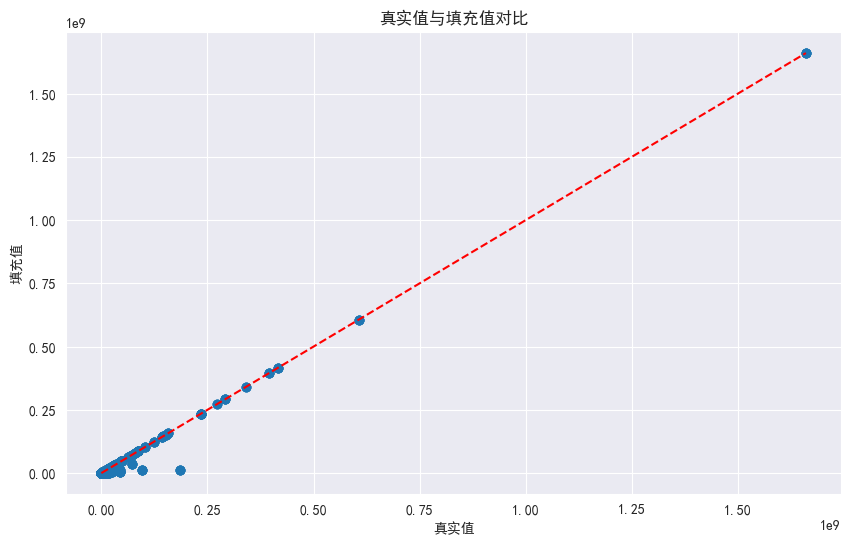

In [27]:

data = pd.read_excel('../data/raw/TrainDataset2024.xls').drop(columns=['ID'])
data = np.where(data == 999, np.nan, data)
data = pd.DataFrame(data).dropna()

comparison = compare_real_and_imputed(data, nsknn_impute_df, k=5)
rmse = calculate_rmse(comparison)
print(f'RMSE: {rmse}')
plot_comparison(comparison)